In [65]:
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import xarray as xr
import pandas as pd
import scipy
from datetime import datetime, timedelta
import time
import seaborn
import matplotlib.dates as mdates
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
import math
import netCDF4 as nc
import requests

# import chemO_funcs #import o2sat
from importlib import reload
import warnings
warnings.filterwarnings('ignore')
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm


# Set up Google Sheets API

In [4]:
import gspread
from df2gspread import df2gspread as d2g
from oauth2client.service_account import ServiceAccountCredentials

scope = [
   'https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
#Name of our Service Account Key
google_key_file = 'servicecredentials-Copy1.json'
credentials = ServiceAccountCredentials.from_json_keyfile_name(google_key_file, scope)
gc = gspread.authorize(credentials)

# GFDL + SOCAT

In [3]:
GFDL_SOCAT = pd.read_csv('/Users/akbaskind/Documents/Python Scripts/YoE/GFDLESM4_SOCAT_May21.csv')

In [94]:
GFDL_SOCAT

,Unnamed: 0,Lat,Lon,GFDL Std Fugacity Detrended,SOCAT Std Fugacity Detrended,GFDL Std pH Detrended,SOCAT Std pH Detrended,GFDL Std Omega Detrended,SOCAT Std Omega Detrended
0,0,-77.5,165.5,70.439747,33.870,0.111884,0.055627,0.449691,0.24730
1,1,-77.5,166.5,72.004162,37.207,0.111023,0.064110,0.447630,0.28289
2,2,-77.5,167.5,79.533071,75.969,0.113909,0.125790,0.516922,0.53831
3,3,-77.5,173.5,67.359107,59.793,0.088186,0.074840,0.370955,0.27016
4,4,-77.5,174.5,67.294759,70.196,0.088165,0.091922,0.371858,0.33790
...,...,...,...,...,...,...,...,...,...
3831,3831,79.5,4.5,36.087558,38.760,0.051899,0.067620,0.173121,0.33734
3832,3832,79.5,5.5,37.034342,32.603,0.052617,0.054675,0.175103,0.25258
3833,3833,79.5,6.5,37.652524,36.510,0.053251,0.054662,0.178797,0.27755
3834,3834,79.5,7.5,37.625430,50.109,0.053228,0.070335,0.184231,0.35592


## Remove MAJOR outliers

I removed outliers by eliminating points where SOCAT Std Fugacity and GFDL Std Fugacity were more than 2 standard deviations away from the global mean SOCAT/GFDL Std Fugacity. This ended up removing outliers from the other metrics as well.

In [34]:
def rmoutliers_STD(dataframe, var, STDs):
    # Calculate the upper and lower limits
    # As defined by 2 standard deviations more/less than mean
    STD = dataframe[var].std()
    MN = dataframe[var].mean()
    LOWER = MN - STDs*STD
    UPPER = MN + STDs*STD

    for ind in dataframe.index:
        if dataframe[var][ind] > UPPER:
            dataframe = dataframe.drop(ind)
        elif dataframe[var][ind] < LOWER:
            dataframe = dataframe.drop(ind)
    df = dataframe.reset_index(drop=True)
    
    return df

In [87]:
test = rmoutliers_STD(GFDL_SOCAT, 'SOCAT Std Fugacity Detrended', 2)
test = rmoutliers_STD(test, 'GFDL Std Fugacity Detrended', 2)

## Linear Regression: GFDL + SOCAT w/ Outliers

Text(0.5, 0.98, 'GFDL + SOCAT: Outliers Included')

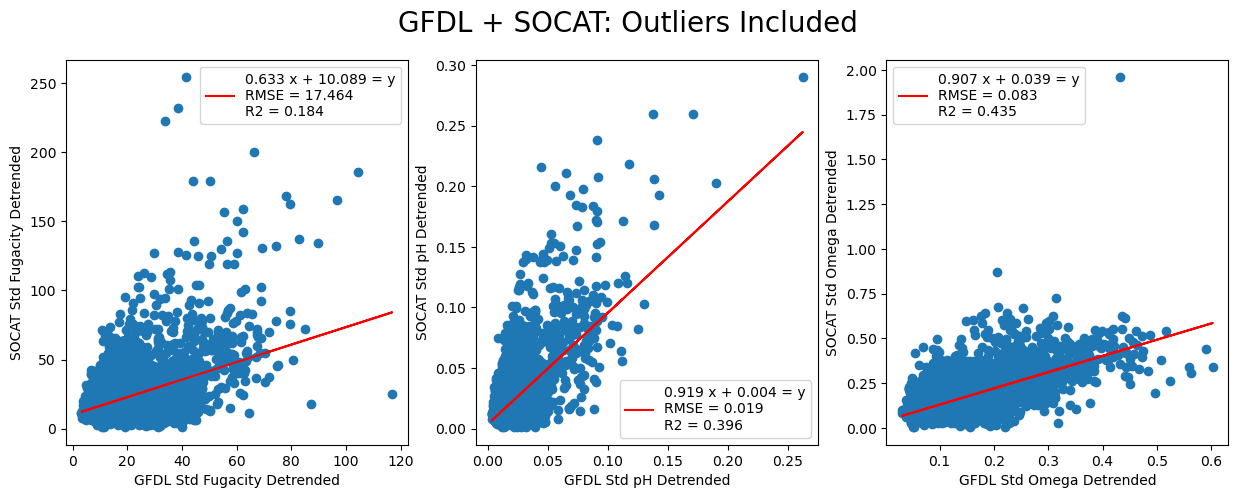

In [92]:
fig, axarr = plt.subplots(ncols = 3, figsize = [15,5])
ax_idx = 0
var = ['Fugacity', 'pH', 'Omega']

for v in var:
    ax = axarr.flat[ax_idx]
    ax.scatter(GFDL_SOCAT['GFDL Std ' + v + ' Detrended'], GFDL_SOCAT['SOCAT Std ' + v + ' Detrended'])
    ax.set_xlabel('GFDL Std ' + v + ' Detrended')
    ax.set_ylabel('SOCAT Std ' + v + ' Detrended')
    
    # Prep for linear regression
    GFDL_SOCAT_ = GFDL_SOCAT.dropna()
    x = GFDL_SOCAT_['GFDL Std ' + v + ' Detrended'].to_numpy() 
    y = GFDL_SOCAT_['SOCAT Std ' + v + ' Detrended'].to_numpy()
    n = np.size(x)
    
    x = x.reshape(-1,1)
    regression_model = LinearRegression()
  
    # Fit the data(train the model)
    regression_model.fit(x, y)
  
    # Predict
    y_predicted = regression_model.predict(x)
  
    # model evaluation
    mse=mean_squared_error(y,y_predicted)
  
    rmse = np.sqrt(mean_squared_error(y, y_predicted))
    r2 = r2_score(y, y_predicted)
    cff = "%.3f" % regression_model.coef_
    intcpt = "%.3f" % regression_model.intercept_
    RMSE = "%.3f" % rmse
    R2 = "%.3f" % r2
    
    lbl = cff + ' x + ' + intcpt + ' = y\nRMSE = ' + RMSE + '\nR2 = ' + R2
    ax.plot(x, y_predicted, color = 'red', label = lbl)
    ax.legend()
    
    ax_idx += 1

fig.suptitle('GFDL + SOCAT: Outliers Included', fontsize=20)

## Linear Regression: GFDL + SOCAT w/out Outliers

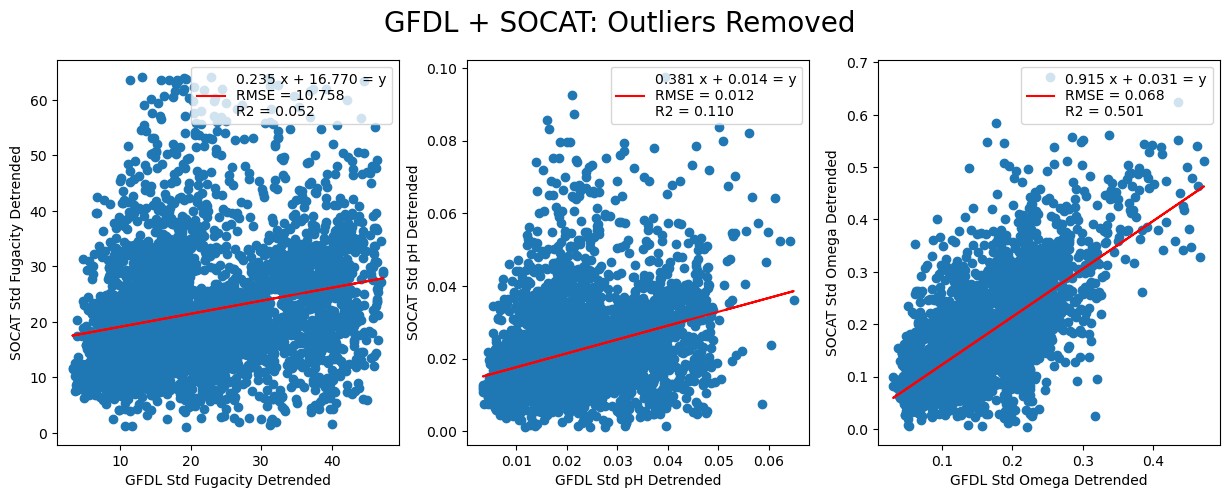

In [97]:
fig, axarr = plt.subplots(ncols = 3, figsize = [15,5])
ax_idx = 0
var = ['Fugacity', 'pH', 'Omega']

for v in var:
    ax = axarr.flat[ax_idx]
    
    # Plot data
    ax.scatter(test['GFDL Std ' + v + ' Detrended'], test['SOCAT Std ' + v + ' Detrended'])
    ax.set_xlabel('GFDL Std ' + v + ' Detrended')
    ax.set_ylabel('SOCAT Std ' + v + ' Detrended')
    
    # Prep for linear regression
    test = test.dropna()
    x = test['GFDL Std ' + v + ' Detrended'].to_numpy() 
    y = test['SOCAT Std ' + v + ' Detrended'].to_numpy()
    n = np.size(x)
    
    x = x.reshape(-1,1)
    regression_model = LinearRegression()
  
    # Fit the data(train the model)
    regression_model.fit(x, y)
  
    # Predict
    y_predicted = regression_model.predict(x)
  
    # model evaluation
    mse=mean_squared_error(y,y_predicted)
  
    rmse = np.sqrt(mean_squared_error(y, y_predicted))
    r2 = r2_score(y, y_predicted)
    cff = "%.3f" % regression_model.coef_
    intcpt = "%.3f" % regression_model.intercept_
    RMSE = "%.3f" % rmse
    R2 = "%.3f" % r2
    
    lbl = cff + ' x + ' + intcpt + ' = y\nRMSE = ' + RMSE + '\nR2 = ' + R2
    ax.plot(x, y_predicted, color = 'red', label = lbl)
    ax.legend()
    
    ax_idx += 1

fig.suptitle('GFDL + SOCAT: Outliers Removed', fontsize=20)
fig.savefig('/Users/akbaskind/Documents/Python Scripts/YOE/GFDL_SOCAT_STD_Linear_NoOutliers.png', bbox_inches='tight')

# GFDL + Buoys

In [95]:
GFDL_buoys = pd.read_csv('/Users/akbaskind/Desktop/YoE/allbuoys_GFDL.csv')
GFDL_buoys.to_csv('/Users/akbaskind/Documents/Python Scripts/YoE/allbuoys_GFD_June18.csv')

## Linear Regression: GFDL + Buoys w/ Outliers

Text(0.5, 0.98, 'GFDL + Buoys: Outliers Included')

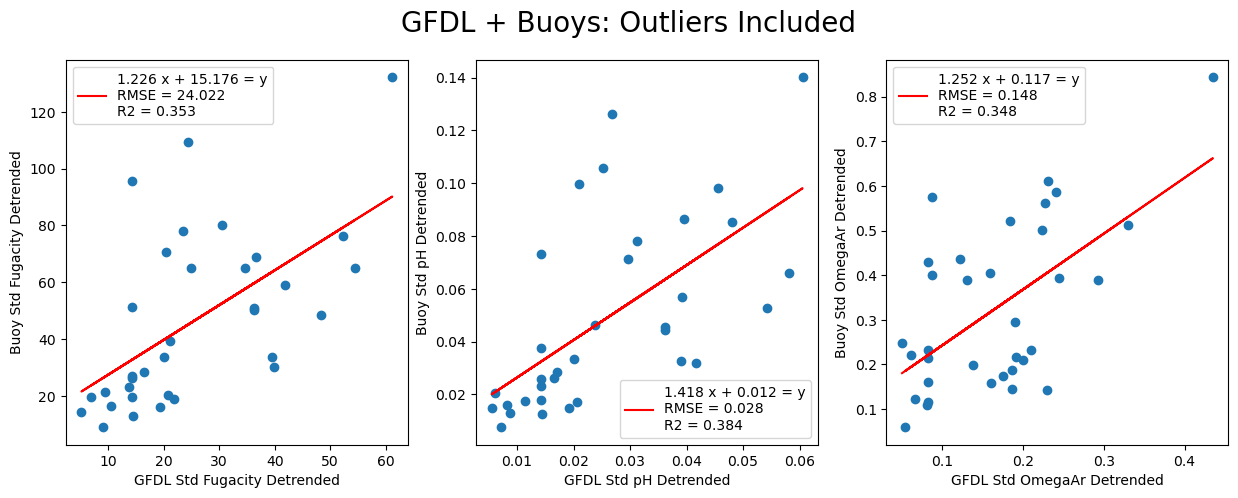

In [90]:
fig, axarr = plt.subplots(ncols = 3, figsize = [15,5])
ax_idx = 0
var = ['Fugacity', 'pH', 'OmegaAr']

for v in var:
    ax = axarr.flat[ax_idx]
    ax.scatter(GFDL_buoys['GFDL Std ' + v + ' Detrended'], GFDL_buoys['Buoy Std ' + v + ' Detrended'])
    ax.set_xlabel('GFDL Std ' + v + ' Detrended')
    ax.set_ylabel('Buoy Std ' + v + ' Detrended')
    
    # Prep for linear regression
    x = GFDL_buoys['GFDL Std ' + v + ' Detrended'].to_numpy() 
    y = GFDL_buoys['Buoy Std ' + v + ' Detrended'].to_numpy()
    n = np.size(x)
    
    x = x.reshape(-1,1)
    regression_model = LinearRegression()
  
    # Fit the data(train the model)
    regression_model.fit(x, y)
  
    # Predict
    y_predicted = regression_model.predict(x)
  
    # model evaluation
    mse=mean_squared_error(y,y_predicted)
  
    rmse = np.sqrt(mean_squared_error(y, y_predicted))
    r2 = r2_score(y, y_predicted)
    cff = "%.3f" % regression_model.coef_
    intcpt = "%.3f" % regression_model.intercept_
    RMSE = "%.3f" % rmse
    R2 = "%.3f" % r2
    
    lbl = cff + ' x + ' + intcpt + ' = y\nRMSE = ' + RMSE + '\nR2 = ' + R2
    ax.plot(x, y_predicted, color = 'red', label = lbl)
    ax.legend()
    
    ax_idx += 1

fig.suptitle('GFDL + Buoys: Outliers Included', fontsize=20)

## Remove outliers

- used 2 standard deviations and applied for all 3 buoy variables

- only 5 buoys ended up being removed

In [62]:
testbuoy = rmoutliers_STD(GFDL_buoys, 'Buoy Std OmegaAr Detrended', 2)
testbuoy = rmoutliers_STD(testbuoy, 'Buoy Std Fugacity Detrended', 2)
testbuoy = rmoutliers_STD(testbuoy, 'Buoy Std pH Detrended', 2)

## Linear Regression: GFDL + Buoys w/out Outliers

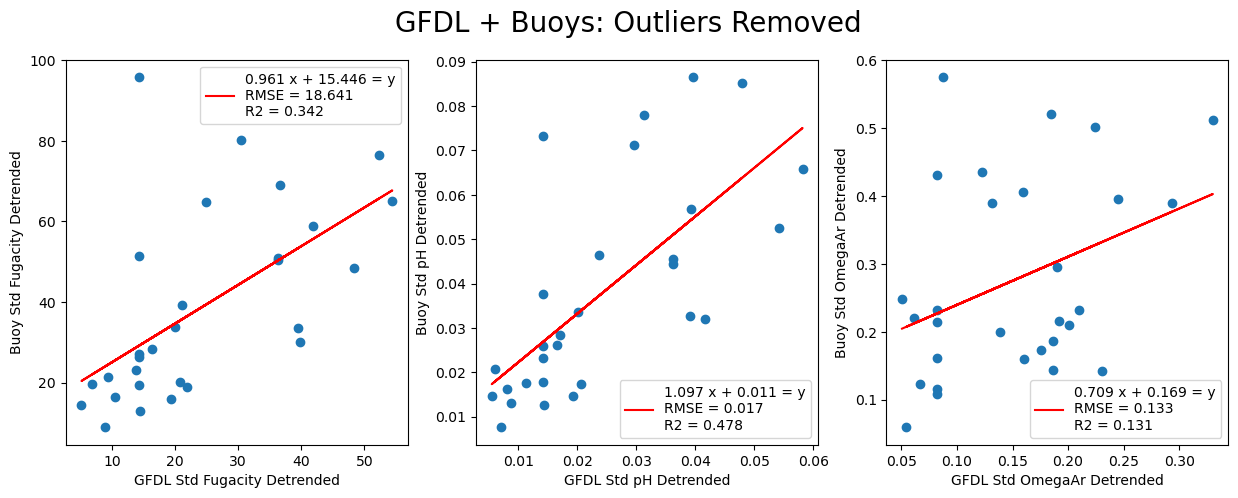

In [96]:
fig, axarr = plt.subplots(ncols = 3, figsize = [15,5])
ax_idx = 0
var = ['Fugacity', 'pH', 'OmegaAr']

for v in var:
    ax = axarr.flat[ax_idx]
    ax.scatter(testbuoy['GFDL Std ' + v + ' Detrended'], testbuoy['Buoy Std ' + v + ' Detrended'])
    ax.set_xlabel('GFDL Std ' + v + ' Detrended')
    ax.set_ylabel('Buoy Std ' + v + ' Detrended')
    
    # Prep for linear regression
    x = testbuoy['GFDL Std ' + v + ' Detrended'].to_numpy() 
    y = testbuoy['Buoy Std ' + v + ' Detrended'].to_numpy()
    n = np.size(x)
    
    x = x.reshape(-1,1)
    regression_model = LinearRegression()
  
    # Fit the data(train the model)
    regression_model.fit(x, y)
  
    # Predict
    y_predicted = regression_model.predict(x)
  
    # model evaluation
    mse=mean_squared_error(y,y_predicted)
  
    rmse = np.sqrt(mean_squared_error(y, y_predicted))
    r2 = r2_score(y, y_predicted)
    cff = "%.3f" % regression_model.coef_
    intcpt = "%.3f" % regression_model.intercept_
    RMSE = "%.3f" % rmse
    R2 = "%.3f" % r2
    
    lbl = cff + ' x + ' + intcpt + ' = y\nRMSE = ' + RMSE + '\nR2 = ' + R2
    ax.plot(x, y_predicted, color = 'red', label = lbl)
    ax.legend()
    
    ax_idx += 1

fig.suptitle('GFDL + Buoys: Outliers Removed', fontsize=20)
fig.savefig('/Users/akbaskind/Documents/Python Scripts/YOE/GFDL_Buoy_STD_Linear_NoOutliers.png', bbox_inches='tight')